# Topic Modeling

This notebook uses Python's Gensim library to perform unsupervised topic modeling on a corpus of Amazon electronic product reviews.

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
from collections import Counter
from tqdm import tqdm
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pyLDAvis 
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

In [82]:
# open csv and continue cleaning
df = pd.read_csv('../final_df.csv')

In [85]:
df = df.dropna()

In [88]:
# ensure single digits and single letters are excluded from the vectorized corpus
df['cleaned'] = df['cleaned'].replace(r'\d+?', ' ', regex=True)
df['cleaned'] = df['cleaned'].replace(r'\s[a-z]\s', ' ', regex=True)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
df.head()

,cleaned,overall
0,professional otr truck driver buy tnd truc...,1.0
1,mount work really well get go problem arm litt...,4.0
2,process turn master bedroom fortress solitude ...,5.0
3,give mount star start box mount wall reall...,3.0
4,buy mount dell monitor fit dell quit...,4.0


In [91]:
df['cleaned'] = [x.split() for x in df['cleaned']]

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [92]:
df.head()

,cleaned,overall
0,"[professional, otr, truck, driver, buy, tnd, t...",1.0
1,"[mount, work, really, well, get, go, problem, ...",4.0
2,"[process, turn, master, bedroom, fortress, sol...",5.0
3,"[give, mount, star, start, box, mount, wall, r...",3.0
4,"[buy, mount, dell, monitor, fit, dell, quite, ...",4.0


In [93]:
# split data into train and test set
X = df[['cleaned']]
y = df['overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# LDA

In [95]:
# create dictionary
dictionary = gensim.corpora.Dictionary(X_train['cleaned'])

# create corpus - mapping of unique word id to word frequency in teh document
bow_corpus = [dictionary.doc2bow(doc) for doc in X_train['cleaned']]

In [97]:
# e.g. (0,1) means word id 0 occurs once in first document
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 2),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 2),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1)]

In [99]:
# Human readable format of corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in bow_corpus[:1]]

[[('actually', 1),
  ('annoyed', 1),
  ('asus', 1),
  ('break', 1),
  ('computer', 1),
  ('customer', 1),
  ('first', 1),
  ('last', 1),
  ('long', 1),
  ('make', 1),
  ('need', 1),
  ('needless', 1),
  ('negotiable', 1),
  ('nice', 1),
  ('non', 1),
  ('oh', 1),
  ('pay', 1),
  ('protest', 1),
  ('return', 1),
  ('say', 2),
  ('service', 1),
  ('shipping', 1),
  ('thing', 1),
  ('week', 2),
  ('work', 1),
  ('worse', 1),
  ('would', 1),
  ('yea', 1),
  ('yet', 1)]]

In [101]:
# Build LDA Model - 10 different topics where each topic is a combo of keywords

lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [103]:
# view the topics 
print(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

[(0, '0.057*"case" + 0.029*"fit" + 0.021*"ipad" + 0.019*"hold" + 0.017*"cover" + 0.016*"tablet" + 0.015*"mount" + 0.013*"plastic" + 0.011*"kindle" + 0.010*"cord"'), (1, '0.117*"battery" + 0.099*"drive" + 0.076*"usb" + 0.069*"charge" + 0.030*"charger" + 0.028*"port" + 0.025*"hard" + 0.024*"gb" + 0.015*"backup" + 0.015*"file"'), (2, '0.030*"work" + 0.028*"get" + 0.025*"one" + 0.019*"would" + 0.018*"use" + 0.017*"good" + 0.016*"buy" + 0.016*"well" + 0.014*"great" + 0.014*"time"'), (3, '0.030*"amazon" + 0.028*"return" + 0.022*"support" + 0.022*"update" + 0.018*"window" + 0.016*"new" + 0.016*"receive" + 0.015*"send" + 0.014*"service" + 0.014*"call"'), (4, '0.062*"cable" + 0.045*"tv" + 0.036*"card" + 0.029*"remote" + 0.027*"video" + 0.018*"monitor" + 0.015*"play" + 0.014*"hd" + 0.014*"hdmi" + 0.014*"app"'), (5, '0.037*"use" + 0.017*"also" + 0.014*"easy" + 0.014*"screen" + 0.014*"like" + 0.013*"light" + 0.013*"small" + 0.013*"nice" + 0.012*"make" + 0.012*"keyboard"'), (6, '0.042*"device" + 0.

In [117]:
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

coherence_model_lda = CoherenceModel(model=lda_model, texts=X_train['cleaned'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.910430158739765

Coherence Score:  0.47367026464284684


In [108]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.264273  0.014873       1        1  38.294834
5      0.251303 -0.081413       2        1  17.295485
6      0.054213  0.178535       3        1   8.997705
0      0.131411 -0.256238       4        1   7.892224
3      0.019805  0.216825       5        1   6.931076
9     -0.039271 -0.078612       6        1   6.162796
4     -0.072909  0.225739       7        1   6.080090
1     -0.176029  0.029485       8        1   3.300658
8     -0.201903 -0.094782       9        1   3.230459
7     -0.230895 -0.154412      10        1   1.814677, topic_info=     Category          Freq        Term         Total  loglift  logprob
160   Default  11593.000000      camera  11593.000000  30.0000  30.0000
753   Default   9397.000000     battery   9397.000000  29.0000  29.0000
255   Default  10634.000000       sound  10634.000000  28.0000  28.0000
153   Default  10941.000000        case  10941.000000  27.0000  27.0000
849   Default   7928.000000       drive   7928.000000  26.0000  26.0000
64    Default  32534.000000         use  32534.000000  25.0000  25.0000
75    Default   9176.000000       cable   9176.000000  24.0000  24.0000
200   Default  26084.000000         get  26084.000000  23.0000  23.0000
343   Default   9405.000000        take   9405.000000  22.0000  22.0000
24    Default  27954.000000        work  27954.000000  21.0000  21.0000
110   Default  23640.000000         one  23640.000000  20.0000  20.0000
298   Default   9180.000000      device   9180.000000  19.0000  19.0000
63    Default   6090.000000         usb   6090.000000  18.0000  18.0000
423   Default   7917.000000        unit   7917.000000  17.0000  17.0000
249   Default   9520.000000     quality   9520.000000  16.0000  16.0000
616   Default   5499.000000      charge   5499.000000  15.0000  15.0000
525   Default  17818.000000        good  17818.000000  14.0000  14.0000
143   Default   6631.000000          tv   6631.000000  13.0000  13.0000
646   Default   5171.000000     picture   5171.000000  12.0000  12.0000
26    Default  17767.000000       would  17767.000000  11.0000  11.0000
829   Default   3762.000000        lens   3762.000000  10.0000  10.0000
1016  Default   5383.000000        card   5383.000000   9.0000   9.0000
494   Default   5314.000000     speaker   5314.000000   8.0000   8.0000
224   Default  15277.000000         buy  15277.000000   7.0000   7.0000
4     Default   6702.000000    computer   6702.000000   6.0000   6.0000
278   Default   5472.000000         fit   5472.000000   5.0000   5.0000
31    Default   5093.000000      amazon   5093.000000   4.0000   4.0000
823   Default   5654.000000       video   5654.000000   3.0000   3.0000
18    Default   5080.000000      return   5080.000000   2.0000   2.0000
51    Default   6025.000000       power   6025.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
1238  Topic10   1603.127930          mm   1604.107422   4.0087  -3.3127
2381  Topic10   1270.019531      filter   1270.999023   4.0085  -3.5456
1972  Topic10   1072.492920   panasonic   1073.472534   4.0084  -3.7147
2351  Topic10    954.338745       nikon    955.318237   4.0082  -3.8314
2225  Topic10    868.127686       lense    869.107117   4.0081  -3.9261
1969  Topic10    827.686829         blu    828.666382   4.0081  -3.9738
830   Topic10    799.942810       sharp    800.922424   4.0080  -4.0079
1226  Topic10    723.890503      single    724.870239   4.0079  -4.1078
1225  Topic10    708.736755        near    709.716431   4.0079  -4.1289
1376  Topic10    668.701416          fm    669.681091   4.0078  -4.1871
2391  Topic10    626.425598     optical    627.405212   4.0077  -4.2524
2747  Topic10    619.114563      sensor    620.094177   4.0077  -4.2641
1171  Topic10    449.100769        hood    450.080231   4.0071  -4.5852
2186  Topic10    439.458649        dslr    440.438171   4.0070  -4.60

In [115]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [116]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=X_train['cleaned'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.5045,"work, get, one, would, use, good, buy, well, g...","[professional, otr, truck, driver, buy, tnd, t..."
1,1,2.0,0.3313,"work, get, one, would, use, good, buy, well, g...",NaN
2,2,0.0,0.3371,"case, fit, ipad, hold, cover, tablet, mount, p...","[process, turn, master, bedroom, fortress, sol..."
3,3,2.0,0.3106,"work, get, one, would, use, good, buy, well, g...","[give, mount, star, start, box, mount, wall, r..."
4,4,5.0,0.3992,"use, also, easy, screen, like, light, small, n...",NaN
5,5,2.0,0.2750,"work, get, one, would, use, good, buy, well, g...","[concerned, hang, tv, wall, get, mount, due, l..."
6,6,2.0,0.6505,"work, get, one, would, use, good, buy, well, g...",NaN
7,7,2.0,0.4428,"work, get, one, would, use, good, buy, well, g...",NaN
8,8,2.0,0.4671,"work, get, one, would, use, good, buy, well, g...",NaN
9,9,5.0,0.3074,"use, also, easy, screen, like, light, small, n...","[price, tablet, love, that, first, design, tab..."


TypeError: object of type 'float' has no len()

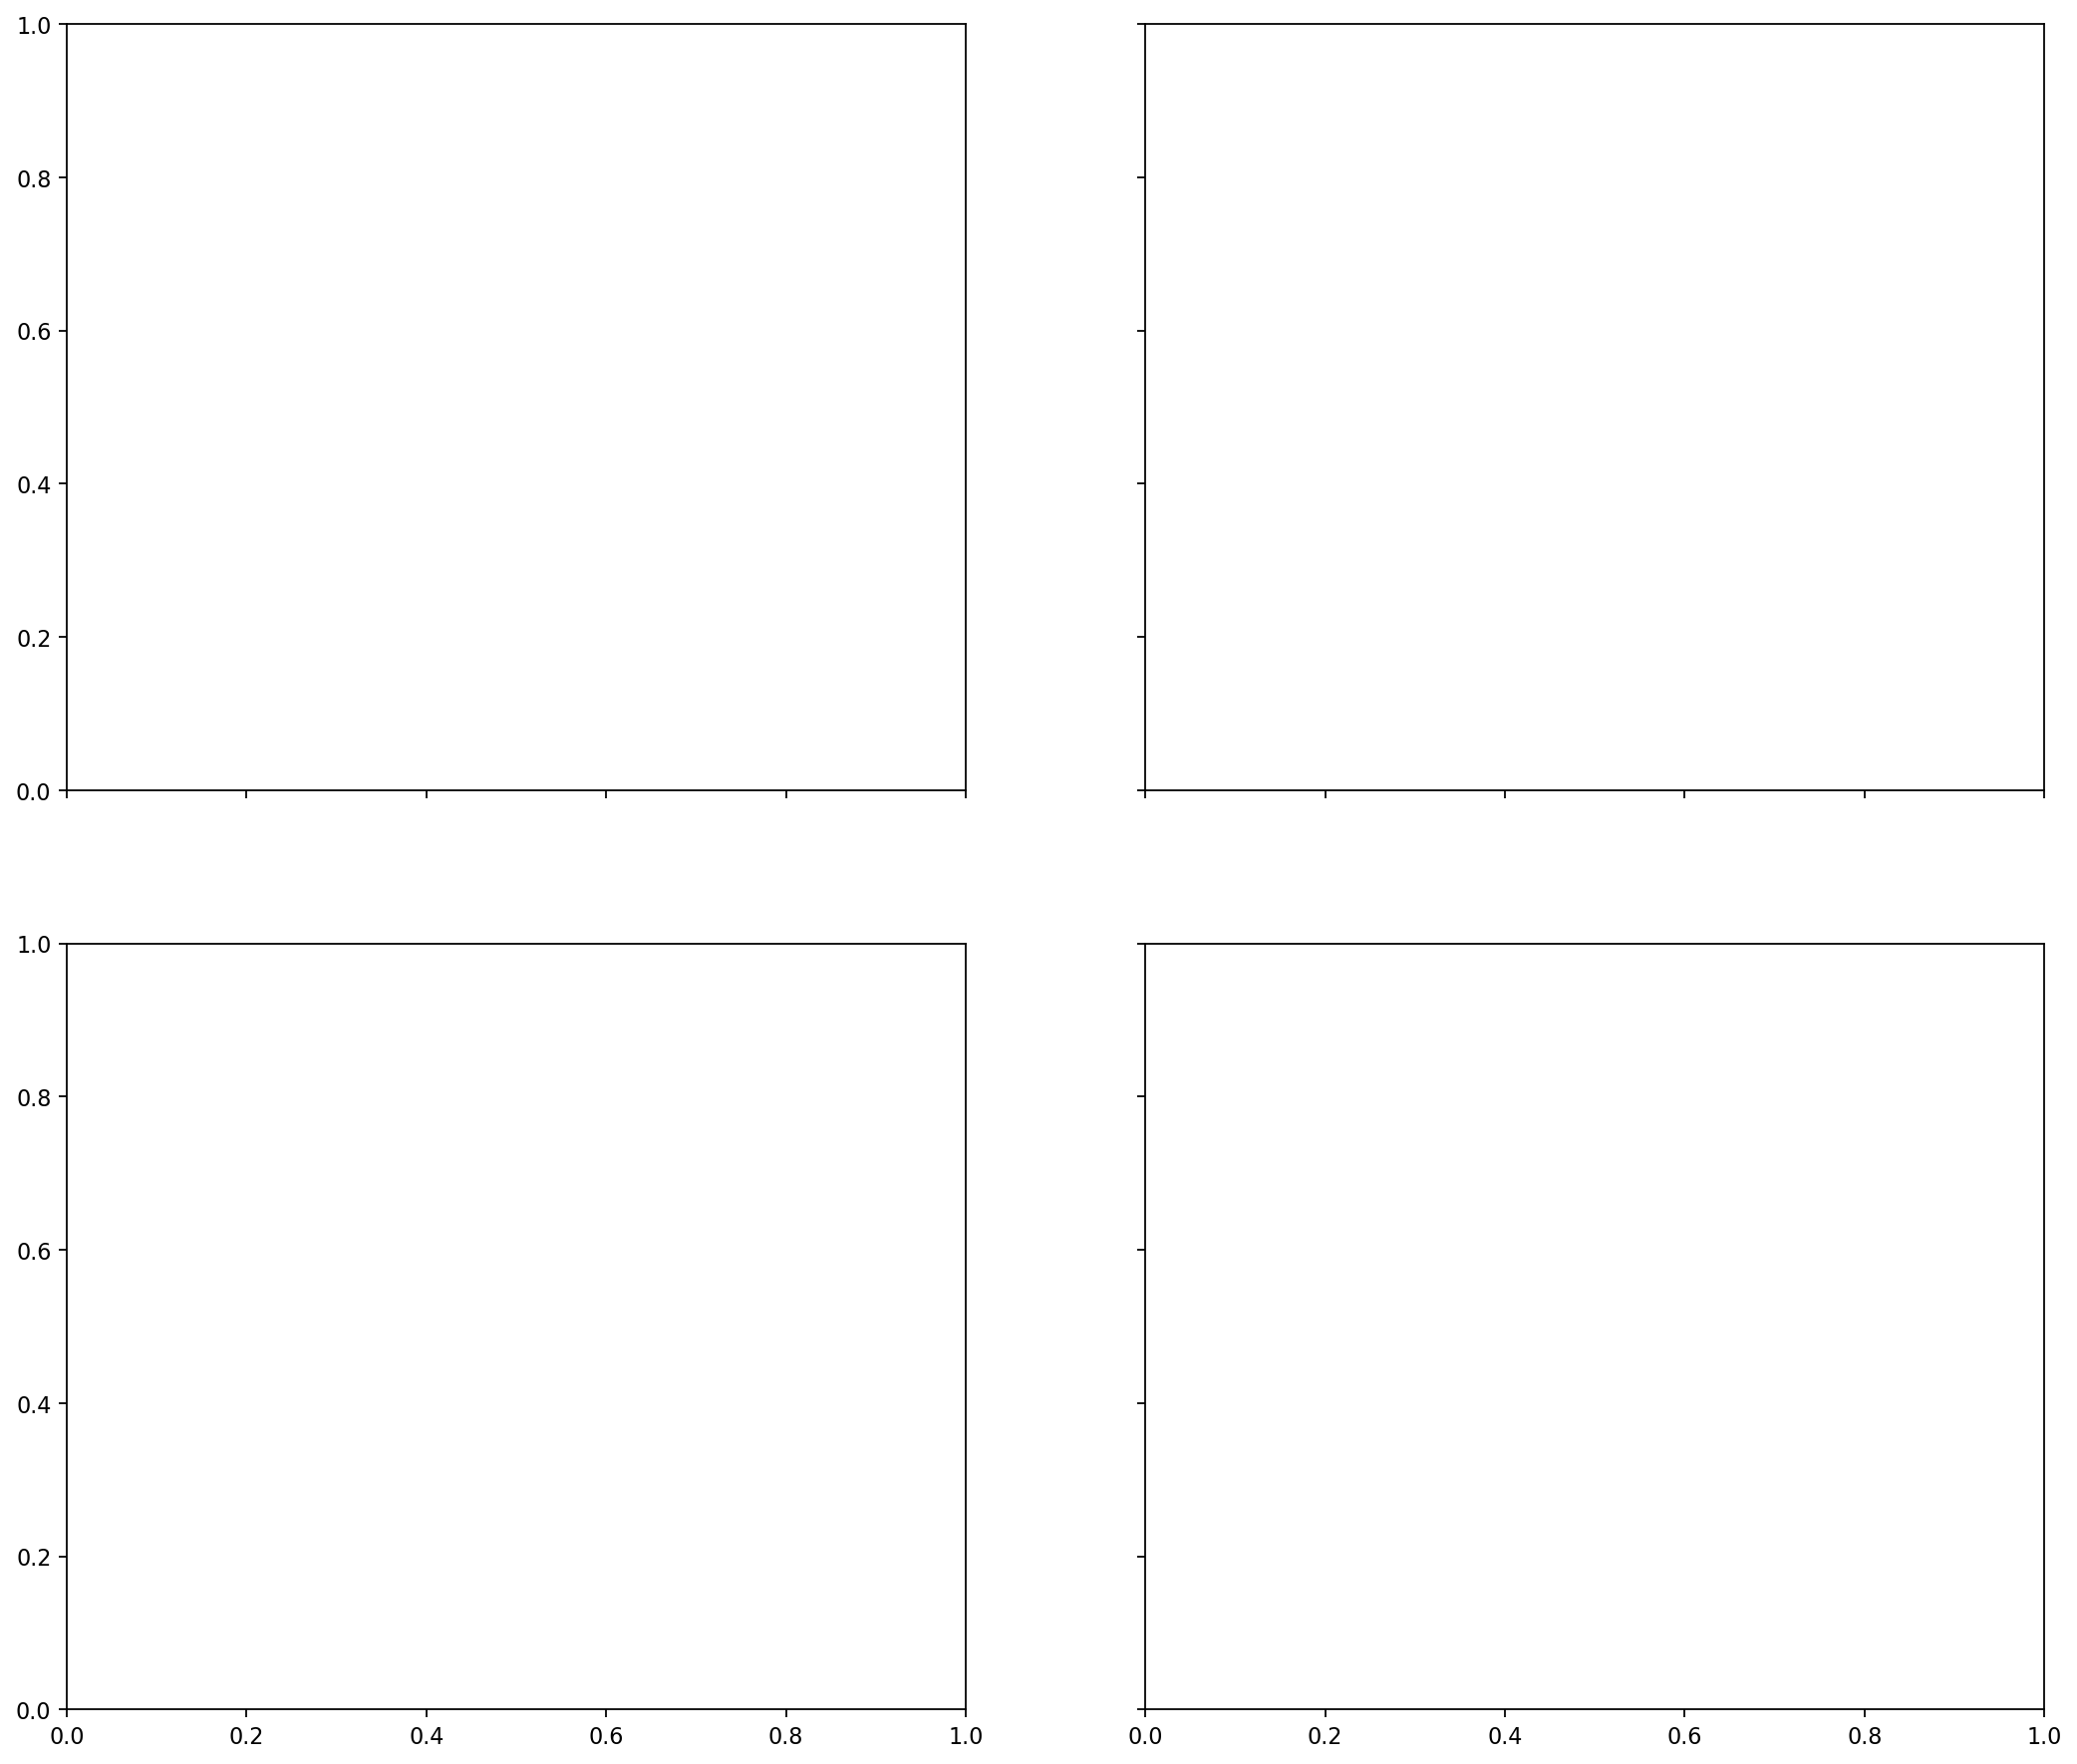

In [118]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [139]:
def create_word_clouds(model, n=2, j=5, save=None, start=None, stop=None):
    """
    create_word_clouds(model, n, j, save, start, stop):
    Params:
        model: gensim LDA model object
        n: number of subplots in a column  (default=2)
        j: number of subplots in a row (default=5)
        save: save the figure (optional, default=0)
        start: from what number topic you wish to create the subplot (optional, default=0)
        stop: stop the subplot at a certain topic (optional, default=None)
        
    Returns:
        Word cloud image for every topic LDA created
    """
    # create color list
    colors_list = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    
    # instantiate cloud
    cloud = WordCloud(background_color='white',
                      width=1028,
                      height=726,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: colors_list[start],
                      prefer_horizontal=1.0)
    
    # extract topics
    topics = model.show_topics(formatted=False)
    
    # create subplots 
    fig, axes = plt.subplots(n, j, figsize=(10,10), sharex=True, sharey=True)
    
    for ax in axes.flatten():
        fig.add_subplot(ax)
        topic_words = dict(topics[start][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(start+1), fontdict=dict(size=16))
        # hide axis
        plt.gca().axis('off')
        start += 1
        if start == stop:
            break
        
    plt.subplots_adjust(wspace=0, hspace=0)
    # hide axis
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.savefig(f'topics_cloud{start}.png',dpi=500)
    plt.show()

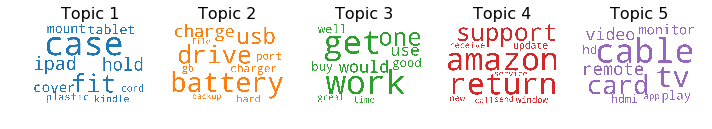

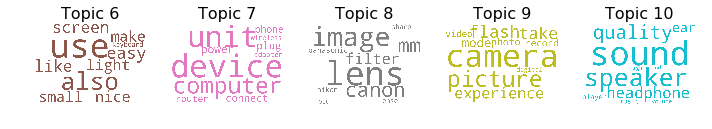

In [140]:
# plot and save the different topics. each word is sized by how many time they repeat
for start in [0, 5]:
    create_word_clouds(lda_model, n=1, j=5, start=start)